In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import mlflow
from sklearn.ensemble import RandomForestClassifier
import sklearn

from sklearn.metrics import accuracy_score
from mlflow.data.pandas_dataset import PandasDataset
from mlflow.models import infer_signature

from sklearn.preprocessing import OneHotEncoder


In [2]:
mlflow.set_tracking_uri("sqlite:///../mlflow.db")
      
client = mlflow.tracking.MlflowClient()

In [3]:
dataset_path = "../data/titanic/"
train_df = pd.read_csv(os.path.join(dataset_path, "train.csv"))
test_df = pd.read_csv(os.path.join(dataset_path, "test.csv"))


print(train_df.shape)
print(test_df.shape)


(891, 12)
(418, 11)


In [42]:
nullseries = test_df.isnull().sum()
print(nullseries[nullseries > 0])

Age       86
Fare       1
Cabin    327
dtype: int64


/tmp/ipykernel_459683/171630453.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(survived_males['Embarked'], color='g', bins=100, hist_kws={'alpha': 0.4})


ValueError: could not convert string to float: 'C'

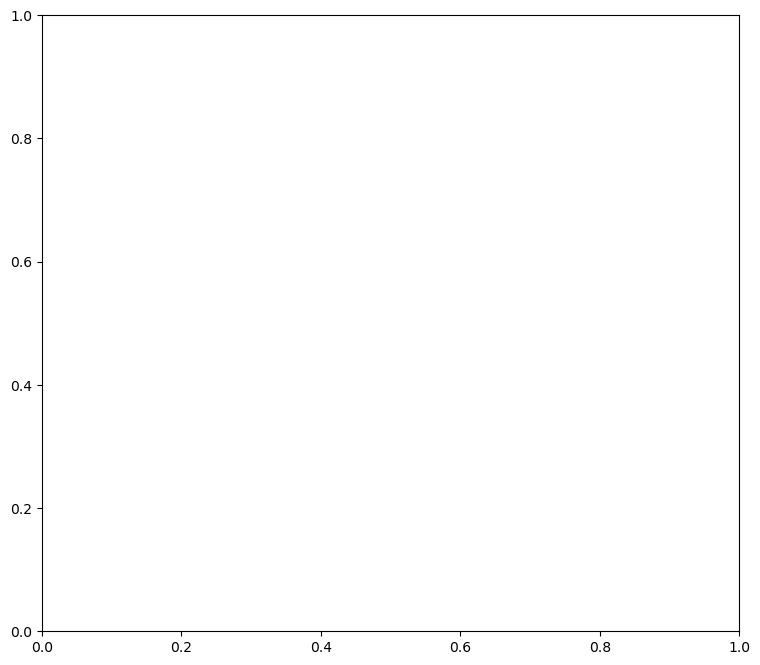

In [78]:
plt.figure(figsize=(9, 8))
survived_males = train_df[(train_df['Survived'] == 1) & (train_df['Embarked'] == "male")]
#survived_males.head(3)
sns.distplot(survived_males['Pclass'], color='g', bins=100, hist_kws={'alpha': 0.4})

In [62]:
train_df[['Last_name', 'First_name']] = train_df['Name'].str.split(',', n=1, expand=True) 
train_df['Title'] = train_df['Name'].map(lambda x: x.split(',')[1].split('.')[0])
train_df['Title'].value_counts()
#train_df.head(4)

Title
 Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Mlle              2
 Major             2
 Col               2
 the Countess      1
 Capt              1
 Ms                1
 Sir               1
 Lady              1
 Mme               1
 Don               1
 Jonkheer          1
Name: count, dtype: int64

In [74]:
df = train_df[['Title', 'Age', 'Fare', 'Survived']].groupby('Title').mean()
df

,Age,Fare,Survived
Title,,,
Capt,70.000000,71.000000,0.000000
Col,58.000000,31.025000,0.500000
Don,40.000000,27.720800,0.000000
Dr,42.000000,49.168457,0.428571
Jonkheer,38.000000,0.000000,0.000000
Lady,48.000000,39.600000,1.000000
Major,48.500000,28.525000,0.500000
Master,4.574167,34.703125,0.575000
Miss,21.773973,43.797873,0.697802


In [66]:
train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_name,First_name,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr. Owen Harris,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs. John Bradley (Florence Briggs Thayer),Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss. Laina,Miss


In [77]:
pd.set_option('display.max_rows', None)
train_df[(train_df['Survived'] == 1) & (train_df['Embarked'] == "S")]
#survived_males['Pclass'].value_counts()
#pd.reset_option('all')

PassengerId  Survived  Pclass  Name                                                      Sex     Age    SibSp  Parch  Ticket             Fare      Cabin        Embarked  Last_name               First_name                                         Title        
4            1         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)              female  35.00  1      0      113803             53.1000   C123         S         Futrelle                 Mrs. Jacques Heath (Lily May Peel)                 Mrs             1
718          1         2       Troutt, Miss. Edwina Celia "Winnie"                       female  27.00  0      0      34218              10.5000   E101         S         Troutt                   Miss. Edwina Celia "Winnie"                        Miss            1
708          1         1       Calderhead, Mr. Edward Pennington                         male    42.00  0      0      PC 17476           26.2875   E24          S         Calderhead               Mr. Edward Penning

In [10]:
titles_map = {
    'Mr' :         'Mr',
    'Mme':         'Mrs',
    'Ms':          'Mrs',
    'Mrs' :        'Mrs',
    'Master' :     'Master',
    'Mlle':        'Miss',
    'Miss' :       'Miss',
    'Capt':        'Officer',
    'Col':         'Officer',
    'Major':       'Officer',
    'Dr':          'Officer',
    'Rev':         'Officer',
    'Jonkheer':    'Royalty',
    'Don':         'Royalty',
    'Sir' :        'Royalty',
    'Countess':    'Royalty',
    'Dona':        'Royalty',
    'Lady' :       'Royalty'
}

class DataPreprocessor():
    def __init__(self) -> None:
        self.col_index_set = False
        pass

    def extract_title(self, names):
        '''Extracts the title from the passenger names.'''

        return names.str.extract(' ([A-Za-z]+)\.', expand=False).map(titles_map)

    def preprocess_dataset(self, df, test=False):
        in_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Age', 'Embarked', 'Fare']
        out_features = ['Survived']

        #train_df['Title'] = train_df['Name'].map(lambda x: x.split(',')[1].split('.')[0])
        
        in_df = df.dropna(subset=["Embarked"])
        if not test:
            out_y = in_df[out_features]
        in_df = in_df[in_features]
        in_df.loc[in_df["Age"].isnull(), "Age"] = in_df["Age"].mean()
        in_df.loc[in_df["Fare"].isnull(), "Fare"] = in_df["Fare"].mean()
        in_df['Male'] = in_df['Sex'].map(lambda x: True if x=="male" else False)
        in_df['Title'] = self.extract_title(df['Name'])    

        titles = set(titles_map.values())
        for title in titles:
            in_df['is_' + title] = in_df['Title'].map(lambda x: True if x==title else False)

        for embarked in ['C', 'Q', 'S']:
            in_df['Embarked_' + embarked] = in_df['Embarked'].map(lambda x: True if x==embarked else False)

        for Pclass in [1, 2, 3]:
            in_df['Pclass_' + str(Pclass)] = in_df['Pclass'].map(lambda x: True if x==Pclass else False)

        in_df['FamilySize'] = in_df['SibSp'] + in_df['Parch']
        in_df['FarePerPerson'] = in_df['Fare'] / (1 + in_df['FamilySize'])

        in_df.drop(columns="Title", inplace=True)
        in_df.drop(columns="Embarked", inplace=True)
        in_df.drop(columns="Sex", inplace=True)
        in_df.drop(columns="Parch", inplace=True)
        in_df.drop(columns="SibSp", inplace=True)
        in_df.drop(columns="Fare", inplace=True)
        in_df.drop(columns="Pclass", inplace=True)

        if self.col_index_set:
            in_df = in_df.reindex(columns = self.train_dumm_cols, fill_value = False)
        else:
            in_df = pd.get_dummies(in_df)
            self.train_dumm_cols = in_df.columns
            self.col_index_set = True

        if test:            
            return in_df
        
        return in_df, out_y

t_proc = DataPreprocessor()
x, y = t_proc.preprocess_dataset(train_df)
x.head(3)
print(t_proc.train_dumm_cols)
z = t_proc.preprocess_dataset(test_df, test=True)
z.head()
x[x['FarePerPerson'] == 0]
#z["Title_Royalty"].unique()

Index(['Age', 'Male', 'is_Officer', 'is_Mr', 'is_Miss', 'is_Mrs', 'is_Master',
       'is_Royalty', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'FamilySize', 'FarePerPerson'],
      dtype='object')


,Age,Male,is_Officer,is_Mr,is_Miss,is_Mrs,is_Master,is_Royalty,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,FamilySize,FarePerPerson
179,36.000000,True,False,True,False,False,False,False,False,False,True,False,False,True,0,0.0
263,40.000000,True,False,True,False,False,False,False,False,False,True,True,False,False,0,0.0
271,25.000000,True,False,True,False,False,False,False,False,False,True,False,False,True,0,0.0
277,29.642093,True,False,True,False,False,False,False,False,False,True,False,True,False,0,0.0
302,19.000000,True,False,True,False,False,False,False,False,False,True,False,False,True,0,0.0
413,29.642093,True,False,True,False,False,False,False,False,False,True,False,True,False,0,0.0
466,29.642093,True,False,True,False,False,False,False,False,False,True,False,True,False,0,0.0
481,29.642093,True,False,True,False,False,False,False,False,False,True,False,True,False,0,0.0
597,49.000000,True,False,True,False,False,False,False,False,False,True,False,False,True,0,0.0
633,29.642093,True,False,True,False,False,False,False,False,False,True,True,False,False,0,0.0


In [5]:


def kDataSplit(k, i, data):
    val_ratio = 1.0 / k
    interval = len(data) * val_ratio
    interval = np.floor(interval).astype(np.int16)

    splits = []
    pool = np.array(range(len(data)))
    for j in range(int(1/val_ratio)):
        split = np.random.choice(pool, size=interval, replace=False)
        split = split.tolist()
        splits.append(split)
        pool = pool[np.isin(pool, split, invert=True)]
    #for j in range(len(splits)):
    #    print(len(splits[j]))

    #K-fold Cross-Validation    
    val_pool = splits[i]
    train_pool = []
    for j in range(len(splits)):
        if i == j:
            continue
        train_pool.append(splits[j])
    train_pool = np.hstack(train_pool).tolist()

    train_data = data.iloc(axis=0)[train_pool]
    val_data = data.iloc(axis=0)[val_pool]
    return train_data, val_data

def kCrossVal(k, model_class, model_params, data, preprocessor):
    model = model_class(**model_params)

    sum_score = 0.0

    for i in range(k):
        train_data, val_data = kDataSplit(k, i, data)
        
        X_train, y_train = preprocessor.preprocess_dataset(train_data)
        X_val, y_val = preprocessor.preprocess_dataset(val_data)

        model.fit(X_train, np.ravel(y_train))
        val_pred = model.predict(X_val)
        acc = accuracy_score(y_true=y_val, y_pred=val_pred)
        sum_score += acc
    return sum_score / k

In [6]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def tune_model(df, n_trials, mlflow_exp_name, preprocessor):
    mlflow.set_experiment(mlflow_exp_name)
    experiment = mlflow.get_experiment_by_name(mlflow_exp_name)

    def objective(trial):  
        run = client.create_run(experiment.experiment_id)

        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
            "max_depth": trial.suggest_int("max_depth", 3, 5),
            "random_state": 1,
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 7),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10)
        }
        for key in params:
            client.log_param(run.info.run_id, key, params[key])

        acc = kCrossVal(k=5,
                        model_class=RandomForestClassifier,
                        model_params=params,
                        data=df, 
                        preprocessor=preprocessor)

        client.log_metric(run.info.run_id, "accuracy", acc)
        return acc

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, n_jobs=-1)
    return study.best_trial.params


In [11]:
import uuid
mlflow_exp_name = "titanic-hyp-" + str(uuid.uuid4()).split("-")[0]
preprocessor = DataPreprocessor()
X_train, y_train = preprocessor.preprocess_dataset(train_df)
best_params = tune_model(train_df, 
                         n_trials=100, 
                         mlflow_exp_name=mlflow_exp_name, 
                         preprocessor=preprocessor)

mlflow.set_experiment("titanic")
mlflow.sklearn.autolog(disable=True)
with mlflow.start_run(run_name='rf_baseline'):
    mlflow.set_tag("model_name", "RF")    

    model = RandomForestClassifier(**best_params)
    param = model.get_params()
    
    model.fit(X_train, np.ravel(y_train))

    acc = kCrossVal(k = 5, 
                    model_class = RandomForestClassifier, 
                    model_params = param, 
                    data = train_df,
                    preprocessor=preprocessor)

    joined_train = pd.concat((X_train,y_train),axis=1)
    mlflow_train_dataset: PandasDataset = mlflow.data.from_pandas(joined_train)
    mlflow.log_input(mlflow_train_dataset, context="training")
    mlflow.log_params(params=param)
    mlflow.log_metric("accuracy", acc)
    signature = infer_signature(model_input=X_train, model_output=y_train)
    mlflow.sklearn.log_model(model, "sk_models", signature=signature)

    print(acc)
        

2023/09/15 18:54:09 INFO mlflow.tracking.fluent: Experiment with name 'titanic-hyp-ee4907f1' does not exist. Creating a new experiment.


/home/tomislav/mambaforge-pypy3/envs/titanic_env/lib/python3.11/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
/home/tomislav/mambaforge-pypy3/envs/titanic_env/lib/python3.11/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-inte

0.8214858064553361


In [8]:
import filecmp
old_submission = '../kaggle/titanic/submission1.csv'
new_submission = '../kaggle/titanic/submission.csv'

if os.path.exists(new_submission):
    os.remove(new_submission)

logged_model = 'runs:/aae4c28c0a3d42b689e2f859aba5d77e/sk_models'

ml_model = mlflow.sklearn.load_model(logged_model)

X_test = preprocessor.preprocess_dataset(test_df, test=True)

predictions = ml_model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_df.PassengerId,
                       'Survived': predictions})
output.to_csv(new_submission, index=False)

is_diff = filecmp.cmp(old_submission, new_submission, shallow=False)

print("New submission same as old? " + str(is_diff))
print("Your submission was successfully saved!")

New submission same as old? False
Your submission was successfully saved!


In [22]:
X_test = preprocessor.preprocess_dataset(test_df, test=True)

predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_df.PassengerId,
                       'Survived': predictions})
output.to_csv('../kaggle/titanic/submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
